In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel


Load Dataset

In [ ]:
df = pd.read_csv("fake.csv.zip")
df = df[['title', 'text', 'type']]
df.dropna(inplace=True)

df['content'] = df['title'] + " " + df['text']

X = df['content']
y = df['type']

print("Dataset size:", df.shape)
print("\nClass distribution:")
print(y.value_counts())


Dataset size: (12273, 4)

Class distribution:
type
bs            10919
conspiracy      412
bias            354
hate            246
state           121
junksci         102
satire          100
fake             19
Name: count, dtype: int64


Train–Validation–Test Split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 8591
Validation size: 1227
Test size: 2455


Text Cleaning & Normalization

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = [t for t in text.split() if t not in stop_words]
    return " ".join(tokens)

X_train = X_train.apply(clean_text)
X_val   = X_val.apply(clean_text)
X_test  = X_test.apply(clean_text)

print("Sample cleaned text:\n", X_train.iloc[0][:300])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sample cleaned text:
 donald trump likely end aid rebels fighting syrian government information donald trump likely end aid rebels fighting syrian government david e sanger november nyt washington presidentelect donald j trump said friday likely abandon american effort support moderate opposition groups syria battling go


TEXT REPRESENTATION

TF-IDF Representation

In [275]:
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=20000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (8591, 20000)


Dense Embeddings Word2Vec Representation

In [276]:
X_train_tok = X_train.apply(str.split)
X_val_tok   = X_val.apply(str.split)
X_test_tok  = X_test.apply(str.split)

w2v = Word2Vec(
    sentences=X_train_tok,
    vector_size=300,
    window=5,
    min_count=3,
    sg=1
)
def doc_vector(tokens, model):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_train_w2v = np.vstack(X_train_tok.apply(lambda x: doc_vector(x, w2v)))
X_val_w2v   = np.vstack(X_val_tok.apply(lambda x: doc_vector(x, w2v)))
X_test_w2v  = np.vstack(X_test_tok.apply(lambda x: doc_vector(x, w2v)))

print("Word2Vec shape:", X_train_w2v.shape)


Word2Vec shape: (8591, 300)


BERT Representation

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert.eval()

def bert_encode(texts, tokenizer, model, max_len=128):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(
                text, truncation=True, padding='max_length',
                max_length=max_len, return_tensors="pt"
            )
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state[:,0,:].squeeze().numpy())
    return np.vstack(embeddings)

X_train_bert = bert_encode(X_train.tolist(), tokenizer, bert)
X_test_bert  = bert_encode(X_test.tolist(), tokenizer, bert)



print("BERT embedding size:", X_train_bert.shape[1])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT embedding size: 768


In [ ]:
np.save("X_train_bert.npy", X_train_bert)
np.save("X_test_bert.npy", X_test_bert)
np.save("y_train.npy", y_train.to_numpy())
np.save("y_test.npy", y_test.to_numpy())

print("BERT embeddings saved.")


BERT embeddings saved.


In [253]:
X_train_bert = np.load("X_train_bert.npy")
X_test_bert  = np.load("X_test_bert.npy")
y_train = np.load("y_train.npy", allow_pickle=True)
y_test  = np.load("y_test.npy", allow_pickle=True)

print("BERT embeddings loaded from disk.")

BERT embeddings loaded from disk.


In [254]:
print("Train BERT shape:", X_train_bert.shape)
print("Test BERT shape :", X_test_bert.shape)


Train BERT shape: (8591, 768)
Test BERT shape : (2455, 768)


In [257]:
# Train BERT shape: (N_train, 768)
# Test BERT shape : (N_test, 768)

In [258]:
import numpy as np

print("NaNs in train:", np.isnan(X_train_bert).sum())
print("Infs in train:", np.isinf(X_train_bert).sum())


NaNs in train: 0
Infs in train: 0


In [259]:
print("Embedding variance (mean):", np.mean(np.var(X_train_bert, axis=0)))


Embedding variance (mean): 0.035196785


In [260]:
norms = np.linalg.norm(X_train_bert, axis=1)

print("Embedding norm stats:")
print("Min :", norms.min())
print("Mean:", norms.mean())
print("Max :", norms.max())


Embedding norm stats:
Min : 11.864564
Mean: 13.661837
Max : 16.10231


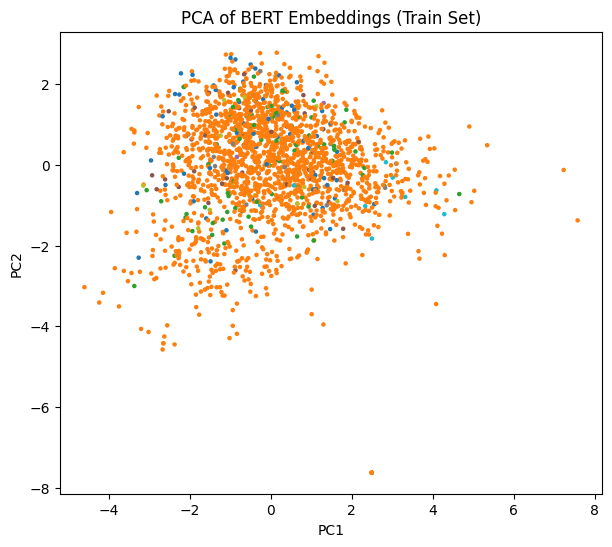

In [262]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd # Import pandas

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_bert[:2000])  # sample for speed

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=pd.Series(y_train[:2000]).astype('category').cat.codes, cmap='tab10', s=5)
plt.title("PCA of BERT Embeddings (Train Set)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [265]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [267]:
SAMPLE_SIZE = 2000

X_sample_idx = np.random.choice(len(y_train), SAMPLE_SIZE, replace=False)
y_sample = y_train[X_sample_idx]


In [268]:
# TF-IDF (convert sparse → dense for PCA)
X_tfidf_sample = X_train_tfidf[X_sample_idx].toarray()

# Word2Vec
X_w2v_sample = X_train_w2v[X_sample_idx]

# BERT
X_bert_sample = X_train_bert[X_sample_idx]


In [282]:
def plot_pca(X, y, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(6,5))
    scatter = plt.scatter(
        X_pca[:,0],
        X_pca[:,1],
        c=pd.Series(y).astype('category').cat.codes,
        cmap='tab10',
        s=5
    )
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

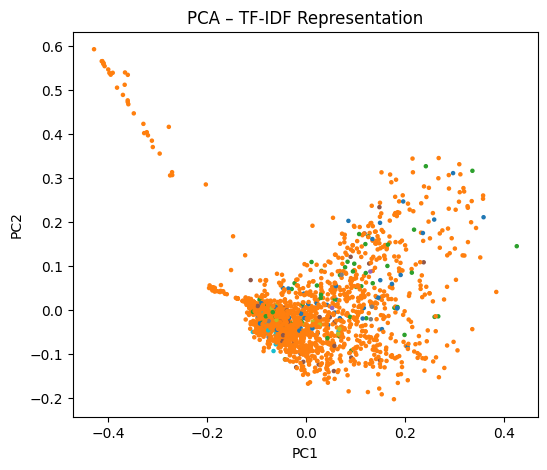

In [272]:
plot_pca(X_tfidf_sample, y_sample, "PCA – TF-IDF Representation")


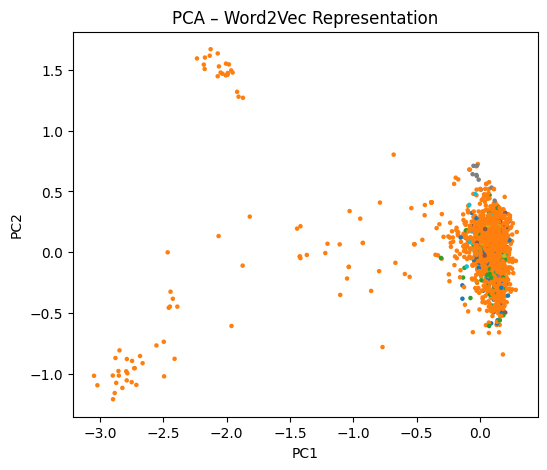

In [273]:
plot_pca(X_w2v_sample, y_sample, "PCA – Word2Vec Representation")


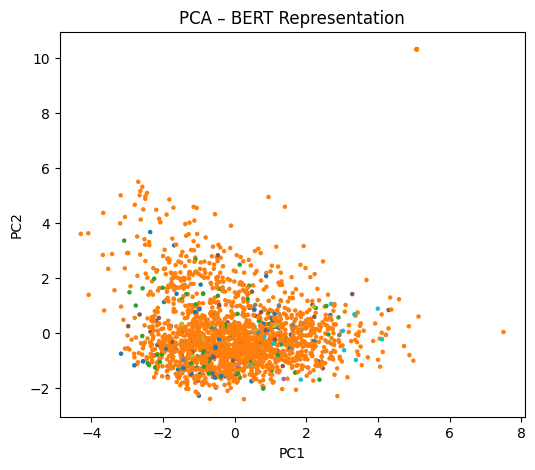

In [274]:
plot_pca(X_bert_sample, y_sample, "PCA – BERT Representation")


IMBALANCE-AWARE LEARNING

In [277]:
ros = RandomOverSampler(random_state=42)

X_train_tfidf_os, y_train_os = ros.fit_resample(X_train_tfidf, y_train)
X_train_w2v_os,   _          = ros.fit_resample(X_train_w2v, y_train)
X_train_bert_os,  _          = ros.fit_resample(X_train_bert, y_train)

print("Oversampling applied to training data only")


Oversampling applied to training data only


In [ ]:
CLASSIFICATION & TRAINING

In [278]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=42
    )
}


Evaluation Function

In [279]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, preds),
        "Macro Precision": precision_score(y_test, preds, average="macro"),
        "Macro Recall": recall_score(y_test, preds, average="macro"),
        "Macro F1": f1_score(y_test, preds, average="macro")
    }


Train & Evaluate on TF-IDF

In [280]:
results_tfidf = {}

for name, model in models.items():
    results_tfidf[name] = evaluate_model(
        model,
        X_train_tfidf_os,
        y_train_os,
        X_test_tfidf,
        y_test
    )

results_tfidf_df = pd.DataFrame(results_tfidf).T
print("TF-IDF Results:\n", results_tfidf_df)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TF-IDF Results:
                      Accuracy  Macro Precision  Macro Recall  Macro F1
Logistic Regression  0.894501         0.542878      0.475682  0.485453
SVM                  0.916090         0.642753      0.440207  0.500437
Naive Bayes          0.684318         0.273170      0.562471  0.321666
Random Forest        0.916090         0.815054      0.282381  0.361405


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train & Evaluate on Word2Vec (NO Naïve Bayes)

In [281]:
models_dense = {
    "Logistic Regression": models["Logistic Regression"],
    "SVM": models["SVM"],
    "Random Forest": models["Random Forest"]
}

results_w2v = {}

for name, model in models_dense.items():
    results_w2v[name] = evaluate_model(
        model,
        X_train_w2v_os,
        y_train_os,
        X_test_w2v,
        y_test
    )

results_w2v_df = pd.DataFrame(results_w2v).T
print("Word2Vec Results:\n", results_w2v_df)


Word2Vec Results:
                      Accuracy  Macro Precision  Macro Recall  Macro F1
Logistic Regression  0.485947         0.212241      0.575524  0.235527
SVM                  0.457434         0.211755      0.557485  0.230834
Random Forest        0.901833         0.702303      0.226455  0.279879


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train & Evaluate on BERT (NO Naïve Bayes)

In [283]:
results_bert = {}

for name, model in models_dense.items():
    results_bert[name] = evaluate_model(
        model,
        X_train_bert_os,
        y_train_os,


        X_test_bert,
        y_test
    )

results_bert_df = pd.DataFrame(results_bert).T
print("BERT Results:\n", results_bert_df)


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


BERT Results:
                      Accuracy  Macro Precision  Macro Recall  Macro F1
Logistic Regression  0.740122         0.287020      0.444066  0.329537
SVM                  0.719348         0.285479      0.426319  0.321423
Random Forest        0.899796         0.362346      0.164941  0.186865


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
